## ewf-wfp-02-02-02 - Snow Cover Climatology

Snow Cover Climatology

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'Snow Cover Climatology'),
                ('abstract', 'Snow Cover Climatology'),
                ('id', 'ewf-wfp-02-02-02')])

### <a name="parameter">Parameter Definition 

In [2]:
#nameOfRegion = dict([('id', 'nameOfRegion'),
#                     ('value', 'CentralAsia'),
#                     ('title', 'Name of Region'),
#                     ('abstract', 'Name of the region of interest'),
#                     ('minOccurs', '1')])

In [3]:
indexAggCat = dict([('id', 'indexAggCat'),
             ('value', 'better-wfp-02-02-01'),
             ('title', 'indexAggCat'),
             ('abstract', 'index to access catalog of aggregated land surface temperature time series'),
             ('minOccurs', '1')])

In [4]:
apikeyAggCat = dict([('id', 'apikeyAggCat'),
                ('value', 'AKCp5dKiUNkRR38SXQAxLKLMZKUKcNM3skuJ1ZrbULdjeJBTGBgmzvqtWeowxk4FmYNdXh7sR'),
                ('title', 'apikeyAggCat'),
                ('abstract', 'apikey to access indexAggCat catalog'),
                ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [5]:
# 2015, 2016, 2017
#averages
#input_identifiers = ('SCNDays_MTerra_h19v04_2015_2016.tif', 'SCNDays_MTerra_h19v04_2016_2017.tif', 'SCNDays_MTerra_h19v05_2015_2016.tif', 'SCNDays_MTerra_h19v05_2016_2017.tif', 'SCNDays_MTerra_h19v06_2015_2016.tif', 'SCNDays_MTerra_h19v06_2016_2017.tif')
input_identifiers = (
 '5E963E57BE69EFFADB621DDB31E19E276C22D42A',
 'B77070E553D873607FC364B65C0D4626BFACBB54')
#maxvalues
#input_identifiers = ('LST_SouthernAfrica_N3_maxvalues_2015-01-05_2015-01-25.tif', 'LST_SouthernAfrica_N3_maxvalues_2016-01-05_2016-01-25.tif', 'LST_SouthernAfrica_N3_maxvalues_2017-01-05_2017-01-25.tif')

**Input references**

This is the MODIS stack catalogue references

In [6]:
input_references = ['https://catalog.terradue.com/better-wfp-02-02-01/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers]

**Data path**

This path defines where the data is staged-in. 

In [7]:
data_path = "/workspace/ewf-wfp-02-02-02/src/main/app-resources/notebook/libexec/data"

**Aux folders**

In [8]:
output_folder = ''

In [9]:
temp_folder = 'temp'

#### Import Modules

In [10]:
import os
import shutil

import cioppy
import datetime as dt

import pandas as pd
import geopandas as gpd

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import pdb
ciop = cioppy.Cioppy()

#### Auxiliary vars

In [11]:
check_results = True

#### Auxiliary methods

In [12]:
def get_input_metadata (input_refs):
    
    # for each product get metadata
    Result_Prod = []
    
    for index,product_ref in enumerate(input_refs):
        
        # since the search is by identifier 
        Result_Prod.append(ciop.search(end_point = product_ref,params =[],output_fields='self,identifier,startdate,enclosure,title,startdate,enddate,wkt',creds='{}:{}'.format(indexAggCat['value'],apikeyAggCat['value']))[0] )
    

    input_metadata = gpd.GeoDataFrame.from_dict(Result_Prod)

    input_metadata['startdate'] = pd.to_datetime(input_metadata['startdate'])
    input_metadata['enddate'] = pd.to_datetime(input_metadata['enddate'])
    
    return input_metadata

def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            
    
def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type

#def matrix_sum(mat1, mat2, no_data_value=None):
#    if no_data_value is not None:
#        if not isinstance(mat1, int):
#            mat1[(mat1 == no_data_value)] = 0
#        if not isinstance(mat2, int):
#            mat2[(mat2 == no_data_value)] = 0
#    return mat1 + mat2




def matrix_sum(mat1, mat2, no_data_value=None):
    if no_data_value is not None:
        if not isinstance(mat1, int):
            mat1[(mat1 == no_data_value)] = 0
        if not isinstance(mat2, int):
            mat2[(mat2 == no_data_value)] = 0
            
            
    msum = mat1 + mat2
        
    msum[(mat1 == 0)] = 0
    msum[(mat2 == 0)] = 0
        
    return msum


def write_output_image(filepath, output_matrix, image_format, data_format, output_projection=None, output_geotransform=None, mask=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    if mask is not None:
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
        
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    
    output.FlushCache()
    
def calc_average(matrix_list, n_years):
    if not isinstance(matrix_list, list):
        return 0
    result = matrix_list[0]
    for i in range(1, n_years):
        result = matrix_sum(result, matrix_list[i])
    
    return np.divide(result, (n_years*1.00))

def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list



def calc_lta(file_list):
    
    
    #file_list = []
    #if not os.path.isdir('tmp_data'):
    #    os.mkdir('tmp_data')
    #for enclosure in dataframe['enclosure'].tolist():
    #    filepath = 'tmp_data/' + os.path.basename(enclosure)
    #    status = get_product(enclosure, filepath)
    #    if status == 200:
    #        file_list.append(filepath)
    #print(file_list)
    
    
    
    if file_list:
        
        n_years = len(file_list)
        agr_period_matrix = get_matrix_list(file_list)
        print('Aggregations converted to matrices')
        lta = calc_average(agr_period_matrix, n_years)
        projection, geotransform, no_data_value, data_type = get_metadata(file_list[0])
        
        #for file_ in file_list:
        #    os.remove(file_)
        
        return lta, projection, geotransform, no_data_value, data_type
    
    else:
        return None, None, None
    
    
    

def write_output(temp_folder, lta, period_start_date, period_end_date, product_type, region, projection, geo_transform, image_format, no_data_value, data_type):
    
    #start_day_month = str(period_start_date.month) + '-' + str(period_start_date.day)
    #end_day_month = str(period_end_date.month) + '-' + str(period_end_date.day)
    
    #path_name_ini = os.path.join(temp_folder, 'LTA_' )
    #output_name = temp_folder + '/' + 'LTA_' + product_type + '_' + region + '_' + str(period_N) + '_' + agr_type + '_' + start_day_month + '_' + end_day_month + '_' + str(period_start_date.year) + '_' + str(period_end_date.year) + '.tif'
    
    #output_name = os.path.join(temp_folder, 'LTA_' + product_type + '_' + region +  '_' + start_day_month + '_' + end_day_month + '_' + str(period_start_date.year) + '_' + str(period_end_date.year) + '.tif')
    
    output_name = os.path.join(temp_folder, '_'.join(['LTA', product_type, region, str(period_start_date.year), str(period_end_date.year)]) + '.tif' )
    
    write_output_image(output_name, lta, image_format, data_type, projection, geo_transform, no_data_value=no_data_value)
    return output_name

In [13]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

In [14]:
input_references

['https://catalog.terradue.com/better-wfp-02-02-01/search?format=atom&uid=5E963E57BE69EFFADB621DDB31E19E276C22D42A',
 'https://catalog.terradue.com/better-wfp-02-02-01/search?format=atom&uid=B77070E553D873607FC364B65C0D4626BFACBB54']

In [15]:
input_metadata = get_input_metadata(input_references)
#N = nv
print(input_metadata)
#file_list = [os.path.join(data_path, in_id.split('/')[-1]) for in_id in input_identifiers]


                                           enclosure    enddate  \
0  https://store.terradue.com/better-wfp-02-02-01... 2017-07-28   
1  https://store.terradue.com/better-wfp-02-02-01... 2016-07-27   

                                 identifier  \
0  5E963E57BE69EFFADB621DDB31E19E276C22D42A   
1  B77070E553D873607FC364B65C0D4626BFACBB54   

                                                self  startdate  \
0  https://catalog.terradue.com/better-wfp-02-02-... 2016-08-04   
1  https://catalog.terradue.com/better-wfp-02-02-... 2015-08-05   

                                        title  \
0  Output SCNDays_MTerra_h19v04_2016_2017.tif   
1  Output SCNDays_MTerra_h19v04_2015_2016.tif   

                                                 wkt  
0  POLYGON((12.9805303891434 39.8218653179575,15....  
1  POLYGON((12.9805303891434 39.8218653179575,15....  


In [16]:
file_list = [os.path.join(data_path, os.path.basename(enclosure).split('?')[0]) for enclosure in input_metadata['enclosure']]
file_list

['/workspace/ewf-wfp-02-02-02/src/main/app-resources/notebook/libexec/data/SCNDays_MTerra_h19v04_2016_2017.tif',
 '/workspace/ewf-wfp-02-02-02/src/main/app-resources/notebook/libexec/data/SCNDays_MTerra_h19v04_2015_2016.tif']

#### Workflow

Compute Long Term Averages

In [17]:
#input_metadata = get_input_metadata(input_references)
#N = nv

#file_list = [os.path.join(data_path, in_id.split('/')[-1]) for in_id in input_identifiers]
#file_list = [os.path.join(data_path, os.path.basename(enclosure).split('?')[0]) for enclosure in input_metadata['enclosure']]

#file_list

lta, projection, geotransform, no_data_value, data_type = calc_lta(file_list)




Aggregations converted to matrices


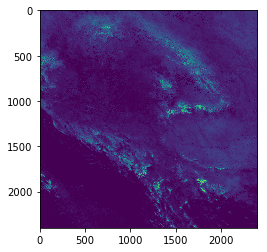

In [18]:
# CHECK
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(lta)
    plt.show()

#### write output

In [19]:
import datetime as dt

filename = os.path.splitext(os.path.basename(file_list[0]))[0].split('_')

#startdate = '2015-01-05
#enddate = '2017-01-25'

#startdate = os.path.splitext(os.path.basename(file_list[0]))[0].split('_')[-2]
#enddate = os.path.splitext(os.path.basename(file_list[-1]))[0].split('_')[-1]

#startdate = dt.datetime.strptime(startdate, '%Y')
#enddate = dt.datetime.strptime(enddate, '%Y')

startdate = input_metadata.sort_values('startdate')['startdate'].iloc[0]
enddate = input_metadata.sort_values('enddate')['enddate'].iloc[-1]
region = filename[-3]
prod_type = filename[-4] + '_' + filename[0]
print(filename)
print(region)
print(prod_type)


if lta is not None:
    #pdb.set_trace()
    filename = write_output(output_folder, lta, startdate, enddate, prod_type, region, projection, geotransform, 'GTiff', no_data_value, data_type)
    print(filename)
    #write_properties_file(match, filename) # TODO
    
#lta[310,210]




['SCNDays', 'MTerra', 'h19v04', '2016', '2017']
h19v04
MTerra_SCNDays
LTA_MTerra_SCNDays_h19v04_2015_2017.tif


In [20]:
# CHECK

# CHECK
#if check_results:
#    
#    import rasterio
#
#    from rasterio.plot import show



#    # Load data
#    raster = filename

#    data = rasterio.open(raster)

#    show(data)

    #data = georasters.from_file(raster)

    # Plot data
    # data.plot()

#### Remove temporay files and folders

In [21]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)